In [23]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import copy
from PIL import Image
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from loader.MNIST_dataset import MNIST_dataset
import random
import os

seed = 0
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
# if you don't have gpu, 
device = f'cuda:0'

* In this exercise, you will implement group equivariant convolutional neural network from the paper "Group Equivariant Convolutional Networks (2016, T. Cohen et al.)". 

1. Implementing group action

First, we implement a simple group action of the cyclic group $c4$. The group $c4$ is consists of rotations by 90 degrees. A matrix parameterization of this group is:

$G(r) = \left[\begin{array}{cc} 
\cos(r\pi/2) & -\sin(r\pi/2)\\
\sin(r\pi/2) & \cos(r\pi/2)
\end{array}\right]$

where $0 \leq r \leq 3$ and $r \in \mathbb{R}$. The group operation is given by the summation of the angle. We assume that the group elements of $c4$ are represented as the integers $r * \pi / 2$ (i.e., $0, \pi/2, \pi, 3\pi/2$ ), and solve the below programming problems under this assumption.

(a) Write the code for the group operations on $c4$. 

In [45]:
class C4Group(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.register_buffer('identity', torch.Tensor([0.]))
        self.order = torch.tensor(4)

    def elements(self):
        """ 
        out: a tensor containing all group elements in this group.
        """

        out = torch.linspace(
            start=0,
            end=2 * np.pi * float(self.order - 1) / float(self.order),
            steps=self.order,
            device=self.identity.device
        )

        return out

    def product(self, h1, h2):
        """ 
        h1: group element 1 
        h2: group element 2
        out: group product of two group elements
        """
        
        out = torch.remainder(h1 + h2, 2 * np.pi)

        return out

    def inverse(self, h):
        """ 
        h: group element
        out: group inverse of the group element 
        """

        out = torch.remainder(-h, 2 * np.pi)

        return out

    def matrix_representation(self, h):
        """ 
        h: group element
        out: matrix representation in R^2 for the group element.
        """
        cos_t = torch.cos(h)
        sin_t = torch.sin(h)

        out = torch.tensor([
            [cos_t, -sin_t],
            [sin_t, cos_t]
        ], device=self.identity.device)

        return out

    def left_action_on_R2(self, batch_h, batch_x):
        """
        batch_h: batch of group elements (b)
        batch_x: vectors defined in R2   (i, x, y)
        out: left action of the elements on a set of vectors in R2 (b, x, y, i)
        """

        batch_h_matrix = torch.stack([self.matrix_representation(h) for h in batch_h]) # matrix representation
        out = torch.einsum('boi,ixy->bxyo', batch_h_matrix, batch_x) # left action
        out = out.roll(shifts=1, dims=-1) # swap x and y coordinates
        return out

    def left_action_on_H(self, batch_h, batch_h_prime):
        """ 
        batch_h: batch of group elements (b)
        batch_h_prime: batch of group elements (b)
        out: batchwise left group actions (b, b)
        """
        transformed_batch_h = self.product(batch_h.repeat(batch_h_prime.shape[0], 1),
                                           batch_h_prime.unsqueeze(-1))
        return transformed_batch_h

    # this is not the problem
    def normalize_group_elements(self, h):
        """ Normalize values of group elements to range between -1 and 1.
        The group elements range from 0 to 2pi * (self.order - 1) / self.order,
        so we normalize by

        @param h: A group element.
        :return:
        """
        largest_elem = 2 * np.pi * (self.order - 1) / self.order

        return (2*h / largest_elem) - 1.

* Your code should pass some example test code.
* For this purpose, let's visualize the group action on the image of the arrow.

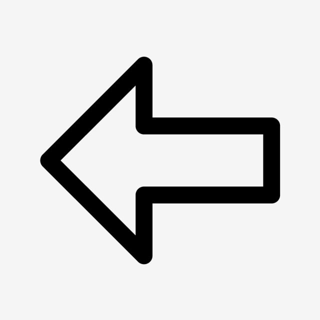

In [46]:
img = Image.open("figures/arrow.jpg")
img = img.resize((320, 320))
img_tensor = transforms.ToTensor()(img)
img

* creates a grid of the pixel locations in our image

In [47]:
img_grid_R2 = torch.stack(torch.meshgrid(
    torch.linspace(-1, 1, img_tensor.shape[-1]),
    torch.linspace(-1, 1, img_tensor.shape[-2]),
))

img_grid_R2.shape

torch.Size([2, 320, 320])

* If your code works well, the below code should output the four figures of the rotating arrows something like that:

![rotating_arrows](figures/rotating_arrows.PNG)  

* Run the code!

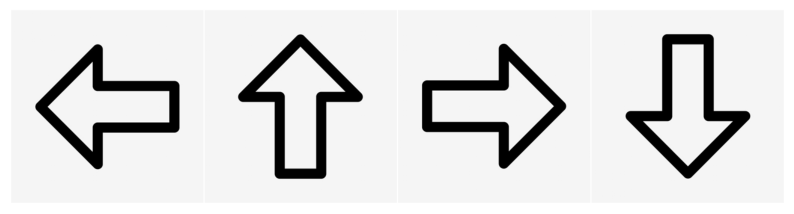

In [48]:
c4 = C4Group()
transformed_img_list = []
for g in c4.elements():
    transformed_grid = c4.left_action_on_R2(g.unsqueeze(0), img_grid_R2)
    transformed_img = torch.nn.functional.grid_sample(img_tensor.unsqueeze(0), transformed_grid, align_corners=True)
    transformed_img_list.append(transformed_img)

x_img = make_grid(torch.cat(transformed_img_list), nrow=4, value_range=(0, 1), pad_value=1)
plt.imshow(x_img.permute(1,2,0))
plt.axis('off')
plt.show()

2. Implementing convolutions

Then, we implement a group equivariant convolution networks w.r.t. cyclic group $c4$. As shown in the paper, we have to implement two kinds of convolution neural network and one pooling as below:

<img src="figures/gcnn.PNG" alt="gcnn" width="1000"/>

<!-- ![gcnn](figures/gcnn.PNG)  -->

2-1. Z2-P4 convolution

Z2-P4 convolution is of the part:

<img src="figures/gcnn_z2p4.PNG" alt="gcnn_z2p4" width="500"/>

For Z2-P4 convolution network, the filter bank (kernel) class is given as below:

In [49]:
class Z2P4Kernel(torch.nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size=3):
        super().__init__()
        self.group = C4Group()

        self.kernel_size = kernel_size
        self.in_channels = in_channels
        self.out_channels = out_channels

        # create spatial kernel grid. These are the coordinates on which our kernel weights are defined.
        self.register_buffer("grid_R2", torch.stack(torch.meshgrid(
            torch.linspace(-1, 1, self.kernel_size),
            torch.linspace(-1, 1, self.kernel_size),
        )).to(self.group.identity.device))

        # transform the grid by the elements in this group.
        self.register_buffer("transformed_grid_R2", self.create_transformed_grid_R2())

        # create and initialize a set of weights
        self.weight = torch.nn.Parameter(torch.zeros((
            self.out_channels,
            self.in_channels,
            self.kernel_size,
            self.kernel_size
        ), device=self.group.identity.device))

        # Initialize weights using kaiming uniform intialisation
        torch.nn.init.kaiming_uniform_(self.weight.data, a=np.sqrt(5))

    def create_transformed_grid_R2(self):
        """
        Transform the created grid by the group action of each group element.
        This yields a grid (over H) of spatial grids (over R2). In other words,
        a list of grids, each index of which is the original spatial grid transformed by
        a corresponding group element in H.
        """
        # Obtain all group elements.
        group_elements = self.group.elements()

        # Transform the grid defined over R2 with the sampled group elements.
        transformed_grid = self.group.left_action_on_R2(
            self.group.inverse(group_elements),
            self.grid_R2
        )
        return transformed_grid

    def sample(self):
        """ 
        Sample convolution kernels for a given number of group elements
        out: filter bank extending over all input channels,
            containing kernels transformed for all output group elements.
        """
        # We fold the output channel dim into the input channel dim; this allows
        # us to use the torch grid_sample function.
        weight = self.weight.view(
            1,
            self.out_channels * self.in_channels,
            self.kernel_size,
            self.kernel_size
        )

        # We want a transformed set of weights for each group element so
        # we repeat the set of spatial weights along the output group axis
        weight = weight.repeat(self.group.elements().numel(), 1, 1, 1)

        # Sample the transformed kernels
        transformed_weight = torch.nn.functional.grid_sample(
            weight,
            self.transformed_grid_R2,
            mode='bilinear',
            padding_mode='zeros',
            align_corners=True
        )

        # Separate input and output channels
        transformed_weight = transformed_weight.view(
            self.group.elements().numel(),
            self.out_channels,
            self.in_channels,
            self.kernel_size,
            self.kernel_size
        )

        # Put the output channel dimension before the output group dimension.
        transformed_weight = transformed_weight.transpose(0, 1)

        return transformed_weight

(b-1) Below is the figure of the example filter bank. What characteristics does it have?

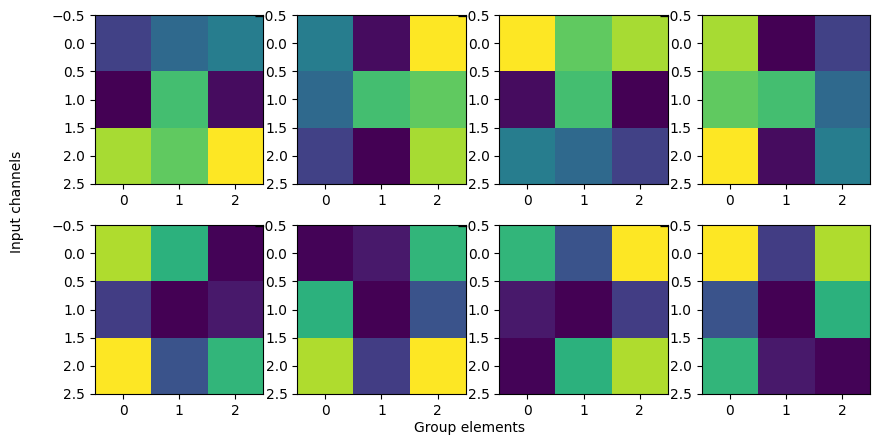

In [50]:
z2p4kernel_1 = Z2P4Kernel(2, 1, kernel_size=3)
weights = z2p4kernel_1.sample()

plt.rcParams['figure.figsize'] = [10, 5]

# pick an output channel to visualize
out_channel_idx = 0

# create [in_channels, group_elements] figures
fig, ax = plt.subplots(weights.shape[2], weights.shape[1])

for in_channel in range(weights.shape[2]):
    for group_elem in range(weights.shape[1]):
        ax[in_channel, group_elem].imshow(
            weights[out_channel_idx, group_elem, in_channel, :, :].detach().numpy()
        )

fig.text(0.5, 0.04, 'Group elements', ha='center')
fig.text(0.04, 0.5, 'Input channels', va='center', rotation='vertical')

plt.show()

(b-2) Using the kernel code (i.e., Z2P4Kernel), write the code for Z2-P4 convolution neural network

In [51]:
class Z2P4Conv(torch.nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size=3):
        super().__init__()
        self.kernel = Z2P4Kernel(in_channels, out_channels, kernel_size=kernel_size)

    def forward(self, x):
        """ 
        Perform Z2-P4 convolution
        x: [batch_dim, in_channels, spatial_dim_1, spatial_dim_2]
        out: [batch_dim, out_channels, num_group_elements, spatial_dim_1, spatial_dim_2]
        """

        # obtain convolution kernels transformed under the group
        conv_kernels = self.kernel.sample()

        # apply convolution
        x = torch.nn.functional.conv2d(
            input=x,
            weight=conv_kernels.reshape(
                self.kernel.out_channels * self.kernel.group.elements().numel(),
                self.kernel.in_channels,
                self.kernel.kernel_size,
                self.kernel.kernel_size
            ),
        ) # [batch_dim, out_channels * num_group_elements, spatial_dim_1,spatial_dim_2]
        
        # reshape
        x = x.view(
            -1,
            self.kernel.out_channels,
            self.kernel.group.elements().numel(),
            x.shape[-1],
            x.shape[-2]
        ) # [batch_dim, out_channels, num_group_elements, spatial_dim_1, spatial_dim_2]

        return x

2-2. P4-P4 Convolution

P4-P4 convolution is of the part:

<img src="figures/gcnn_p4p4.PNG" alt="gcnn_p4p4" width="500"/>

For P4-P4 convolution network, the filter bank (kernel) class is given as below:

In [52]:
class P4P4Kernel(torch.nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size=3):
        super().__init__()
        self.group = C4Group()

        self.kernel_size = kernel_size
        self.in_channels = in_channels
        self.out_channels = out_channels

        # Create a spatial kernel grid
        self.register_buffer("grid_R2", torch.stack(torch.meshgrid(
            torch.linspace(-1, 1, self.kernel_size),
            torch.linspace(-1, 1, self.kernel_size),
        )).to(self.group.identity.device))

        # The kernel grid now also extends over the group H, as our input
        # feature maps contain an additional group dimension
        self.register_buffer("grid_H", self.group.elements())
        self.register_buffer("transformed_grid_R2xH", self.create_transformed_grid_R2xH())

        # create and initialise a set of weights, we will interpolate these
        # to create our transformed spatial kernels. Note that our weight
        # now also extends over the group H
        self.weight = torch.nn.Parameter(torch.zeros((
            self.out_channels,
            self.in_channels,
            self.group.elements().numel(), # this is different from the lifting convolution
            self.kernel_size,
            self.kernel_size
        ), device=self.group.identity.device))

        # initialize weights using kaiming uniform intialisation
        torch.nn.init.kaiming_uniform_(self.weight.data, a=np.sqrt(5))

    def create_transformed_grid_R2xH(self):
        """

        """
        # Sample the group
        group_elements = self.group.elements()

        # Transform the grid defined over R2 with the sampled group elements
        transformed_grid_R2 = self.group.left_action_on_R2(
            self.group.inverse(group_elements),
            self.grid_R2
        )

        # Transform the grid defined over H with the sampled group elements
        transformed_grid_H = self.group.left_action_on_H(
            self.group.inverse(group_elements), self.grid_H
        )

        # Rescale values to between -1 and 1, we do this to please the torch grid_sample
        # function.
        transformed_grid_H = self.group.normalize_group_elements(transformed_grid_H)

        # Create a combined grid as the product of the grids over R2 and H
        # repeat R2 along the group dimension, and repeat H along the spatial dimension
        # to create a [output_group_elem, num_group_elements, kernel_size, kernel_size, 3] grid
        transformed_grid = torch.cat(
            (
                transformed_grid_R2.view(
                    group_elements.numel(),
                    1,
                    self.kernel_size,
                    self.kernel_size,
                    2,
                ).repeat(1, group_elements.numel(), 1, 1, 1),
                transformed_grid_H.view(
                    group_elements.numel(),
                    group_elements.numel(),
                    1,
                    1,
                    1,
                ).repeat(1, 1, self.kernel_size, self.kernel_size, 1, )
            ),
            dim=-1
        )
        return transformed_grid

    def sample(self):
        """ Sample convolution kernels for a given number of group elements

        should return:
        :return kernels: filter bank extending over all input channels,
            containing kernels transformed for all output group elements.
        """

        # fold the output channel dim into the input channel dim; this allows
        # us to use the torch grid_sample function
        weight = self.weight.view(
            1,
            self.out_channels * self.in_channels,
            self.group.elements().numel(),
            self.kernel_size,
            self.kernel_size
        )

        # we want a transformed set of weights for each group element so
        weight = weight.repeat(self.group.elements().numel(), 1, 1, 1, 1)

        # sample the transformed kernels,
        transformed_weight = torch.nn.functional.grid_sample(
            weight,
            self.transformed_grid_R2xH,
            mode='bilinear',
            padding_mode='zeros',
            align_corners=True
        )

        # Separate input and output channels. Note we now have a notion of
        # input and output group dimensions in our weight matrix!
        transformed_weight = transformed_weight.view(
            self.group.elements().numel(), # Output group elements (like in the lifting convolutoin)
            self.out_channels,
            self.in_channels,
            self.group.elements().numel(), # Input group elements (due to the additional dimension of our feature map)
            self.kernel_size,
            self.kernel_size
        )

        # Put the output channel dimension before the output group dimension.
        transformed_weight = transformed_weight.transpose(0, 1)

        return transformed_weight

(c-1) Below is the figure of the example filter bank. What characteristics does it have?

torch.Size([4])
torch.Size([4])
torch.Size([4, 4])


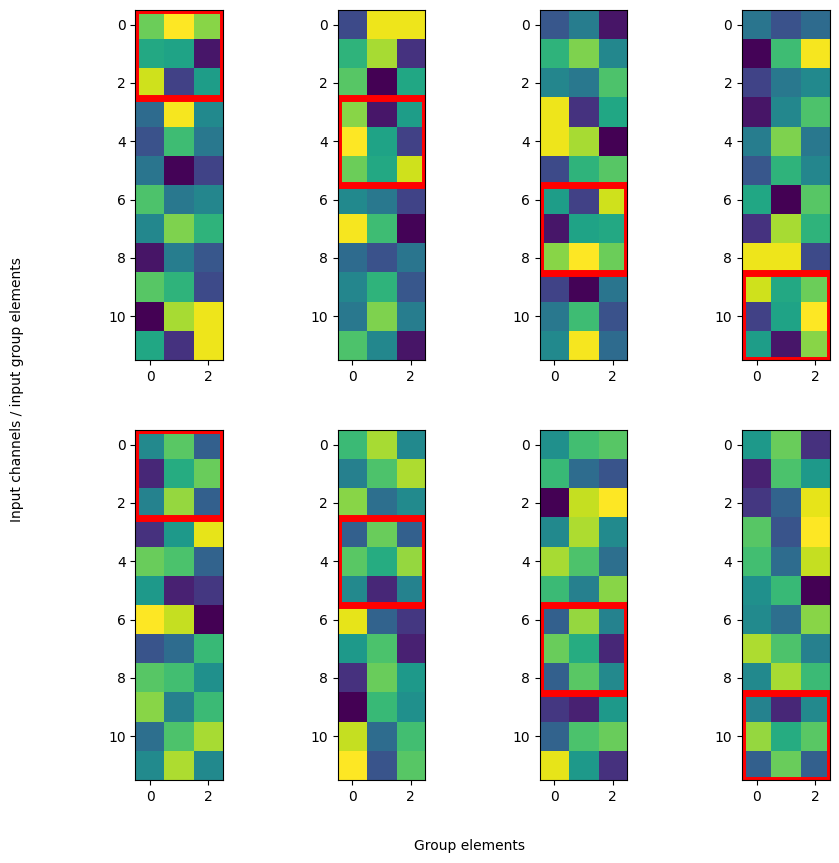

In [53]:
p4p4kernel_1 = P4P4Kernel(2, 8, kernel_size=3)
weights = p4p4kernel_1.sample()
# weights.shape

plt.rcParams['figure.figsize'] = [10, 10]

# For ease of viewing, we fold the input group dimension into the spatial x dimension
weights_t = weights.view(
    weights.shape[0],
    weights.shape[1],
    weights.shape[2],
    weights.shape[3] * weights.shape[4],
    weights.shape[5]
)

# pick an output channel to visualize
out_channel_idx = 0

# create [in_channels, group_elements] figures
fig, ax = plt.subplots(weights.shape[2], weights.shape[1])

for in_channel in range(weights.shape[2]):
    for group_elem in range(weights.shape[1]):
        ax[in_channel, group_elem].imshow(
            weights_t[out_channel_idx, group_elem, in_channel, :, :].detach()
        )

        # Outline the spatial kernel corresponding to the first group element under canonical transformation
        rect = matplotlib.patches.Rectangle(
            (-0.5, group_elem * weights_t.shape[-1] - 0.5), weights_t.shape[-1], weights_t.shape[-1], linewidth=5, edgecolor='r', facecolor='none')
        ax[in_channel, group_elem].add_patch(rect)

fig.text(0.5, 0.04, 'Group elements', ha='center')
fig.text(0.04, 0.5, 'Input channels / input group elements', va='center', rotation='vertical')

plt.show()

(c-2) Using the kernel code (i.e., P4P4Kernel), write the code for P4-P4 convolution neural network

In [33]:
class P4P4Conv(torch.nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size=3):
        super().__init__()

        self.kernel = P4P4Kernel(in_channels, out_channels, kernel_size=kernel_size)

    def forward(self, x):
        """ 
        Perform P4-P4 convolution
        x: [batch_dim, in_channels, num_group_elements, spatial_dim_1, spatial_dim_2]
        out: [batch_dim, out_channels, num_group_elements, spatial_dim_1, spatial_dim_2]
        """

        # We now fold the group dimensions of our input into the input channel
        # dimension
        x = x.reshape(
            -1,
            x.shape[1] * x.shape[2],
            x.shape[3],
            x.shape[4]
        )

        # We obtain convolution kernels transformed under the group
        conv_kernels = self.kernel.sample()

        # apply convolution
        x = torch.nn.functional.conv2d(
            input=x,
            weight=conv_kernels.reshape(
                self.kernel.out_channels * self.kernel.group.elements().numel(),
                self.kernel.in_channels * self.kernel.group.elements().numel(),
                self.kernel.kernel_size,
                self.kernel.kernel_size
            ),
        ) # [batch_dim, out_channels * num_group_elements, spatial_dim_1, spatial_dim_2]

        # reshape
        x = x.view(
            -1,
            self.kernel.out_channels,
            self.kernel.group.elements().numel(),
            x.shape[-1],
            x.shape[-2],
        ) # [batch_dim, out_channels, num_group_elements, spatial_dim_1, spatial_dim_2]

        return x

2-3. P4-Z2 Pooling

P4-Z2 Pooling is of the part:

<img src="figures/gcnn_p4z2.PNG" alt="gcnn_p4z2" width="500"/>

P4-Z2 Pooling is given as below:

In [34]:
class P4Z2Pooling(torch.nn.Module):
    
    def __init__(self):
        super().__init__()

    def forward(self, x):
        x = torch.mean(x, dim=(-3, -2, -1))
        x = x.squeeze()

        return x
        

2-4. Using the developed Z2P4Conv, P4P4Conv, and P4Z2Pooling, we can design an example "group equivariant convolutional neural network" as follows:

In [35]:
class GroupEquivariantCNN(torch.nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = Z2P4Conv(1, 10, kernel_size=3)
        self.conv2 = P4P4Conv(10, 10, kernel_size=3)
        self.conv3 = P4P4Conv(10, 20, kernel_size=3)
        self.conv4 = P4P4Conv(20, 20, kernel_size=3)
        self.pooling = P4Z2Pooling()
        self.fc = torch.nn.Linear(20, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pooling(x)
        x = self.fc(x)
        x = F.log_softmax(x)

        return x
    
    def get_last_channels(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        return x


In [36]:
x_test = torch.rand(8, 1, 64, 64)
eq_net = GroupEquivariantCNN()
y_test = eq_net(x_test)
y_test.shape

torch.Size([4, 4])
torch.Size([4, 4])
torch.Size([4, 4])


/tmp/ipykernel_2706277/568506693.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


torch.Size([8, 10])

* For comparison, we add the original CNN model:

In [37]:
class CNN(torch.nn.Module):
    
    def __init__(self):
        super().__init__()

        self.conv1 = torch.nn.Conv2d(1, 10, kernel_size=3)
        self.conv2 = torch.nn.Conv2d(10, 10, kernel_size=3)
        self.conv3 = torch.nn.Conv2d(10, 20, kernel_size=3)
        self.conv4 = torch.nn.Conv2d(20, 20, kernel_size=3)
        self.fc = torch.nn.Linear(20, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = torch.mean(x, dim=(-2, -1)) # avg pooling
        x = self.fc(x)
        x = F.log_softmax(x)

        return x
    
    def get_last_channels(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        return x



In [38]:
x_test = torch.rand(8, 1, 64, 64)
net = CNN()
y_test = net(x_test)
y_test.shape

/tmp/ipykernel_2706277/1208011322.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


torch.Size([8, 10])

3. Check equivariance of the designed networks

* load MNIST dataset

In [39]:
train_ds = MNIST_dataset(root='datasets', split='training', digits=[0, 1, 2, 3, 4])

MNIST split training | torch.Size([25525, 1, 28, 28])


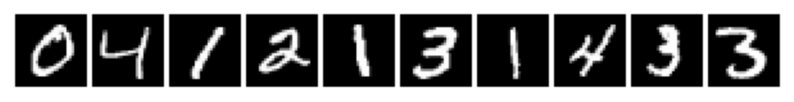

In [40]:
test_x = train_ds.data[:10]
x_img = make_grid(test_x, nrow=10, value_range=(0, 1), pad_value=1)

plt.figure(figsize=(10,10))
plt.imshow(x_img.permute(1,2,0))
plt.axis('off')
plt.show()

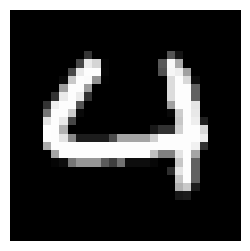

In [41]:
# Get an image from the test dataset.
test_x = train_ds.data[32]
test_img = make_grid(test_x, nrow=1, value_range=(0, 1), pad_value=1)

plt.figure(figsize=(3, 3))
plt.imshow(test_img.permute(1,2,0))
plt.axis('off')
plt.show()

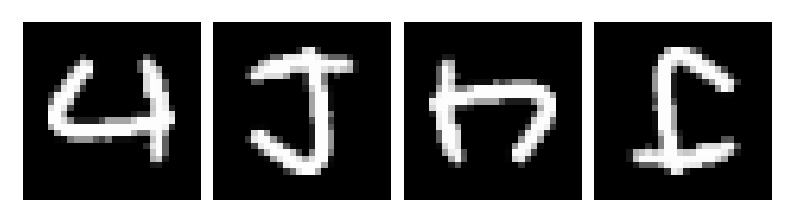

In [42]:
# rotation angles
rots = torch.linspace(0, 360 - 360/4, 4)

# rotate the input image
rot_digit = torch.stack(tuple(torchvision.transforms.functional.rotate(test_x, a.item(), torchvision.transforms.functional.InterpolationMode.BILINEAR) for a in rots))
rot_img = make_grid(rot_digit, nrow=8, value_range=(0, 1), pad_value=1)

plt.figure(figsize=(10,10))
plt.imshow(rot_img.permute(1,2,0))
plt.axis('off')
plt.show()

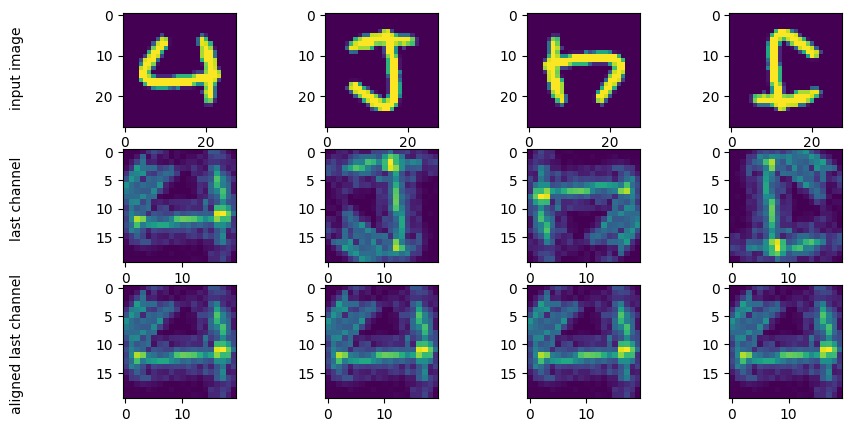

tensor([[-2.2724, -2.2582, -2.4217, -2.3394, -2.1453, -2.3748, -2.4127, -2.3230,
         -2.3794, -2.1455],
        [-2.2724, -2.2582, -2.4217, -2.3394, -2.1453, -2.3748, -2.4127, -2.3230,
         -2.3794, -2.1455],
        [-2.2724, -2.2582, -2.4217, -2.3394, -2.1453, -2.3748, -2.4127, -2.3230,
         -2.3794, -2.1455],
        [-2.2724, -2.2582, -2.4217, -2.3394, -2.1453, -2.3748, -2.4127, -2.3230,
         -2.3794, -2.1455]], grad_fn=<LogSoftmaxBackward0>)


/tmp/ipykernel_2706277/568506693.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


In [43]:
eq_last_channel = torch.mean(
    eq_net.get_last_channels(rot_digit),
    dim=-3
    )[:,0,...]

plt.rcParams['figure.figsize'] = [10, 5]
fig, ax = plt.subplots(3, 4)
for idx in range(4):
    ax[0, idx].imshow(
        rot_digit[idx, 0, :, :].detach().numpy()
    )
    ax[1, idx].imshow(
        eq_last_channel[idx, :, :].detach().numpy()
    )
    ax[2, idx].imshow(
        torch.rot90(eq_last_channel[idx, :, :], k=-idx).detach().numpy()
    )
    
fig.text(0.04, 0.77, 'input image', va='center', rotation='vertical')
fig.text(0.04, 0.51, 'last channel', va='center', rotation='vertical')
fig.text(0.04, 0.22, 'aligned last channel', va='center', rotation='vertical')
plt.show()
print(eq_net(rot_digit))


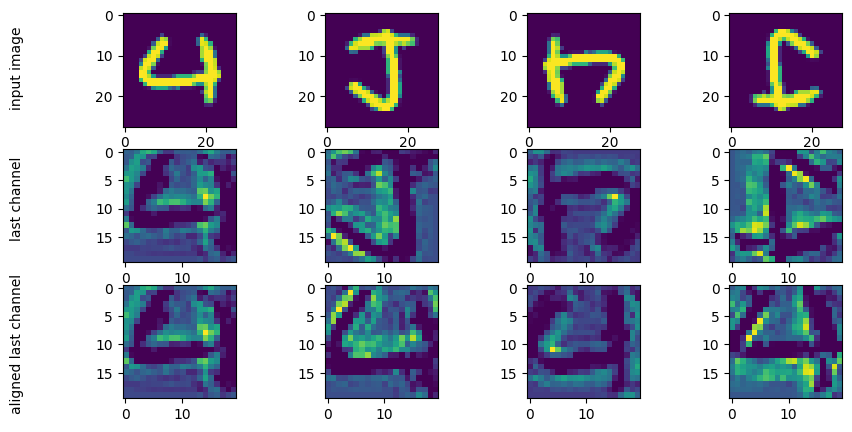

tensor([[-2.3691, -2.2131, -2.1981, -2.2175, -2.4930, -2.2210, -2.2498, -2.3618,
         -2.3340, -2.4143],
        [-2.3691, -2.2127, -2.1981, -2.2175, -2.4933, -2.2211, -2.2497, -2.3615,
         -2.3341, -2.4147],
        [-2.3690, -2.2130, -2.1979, -2.2174, -2.4932, -2.2211, -2.2498, -2.3617,
         -2.3341, -2.4145],
        [-2.3690, -2.2128, -2.1981, -2.2175, -2.4934, -2.2210, -2.2497, -2.3615,
         -2.3340, -2.4147]], grad_fn=<LogSoftmaxBackward0>)


/tmp/ipykernel_2706277/1208011322.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


In [44]:
last_channel = net.get_last_channels(rot_digit)[:,0,...]

plt.rcParams['figure.figsize'] = [10, 5]
fig, ax = plt.subplots(3, 4)
for idx in range(4):
    ax[0, idx].imshow(
        rot_digit[idx, 0, :, :].detach().numpy()
    )
    ax[1, idx].imshow(
        last_channel[idx, :, :].detach().numpy()
    )
    ax[2, idx].imshow(
        torch.rot90(last_channel[idx, :, :], k=-idx).detach().numpy()
    )
    
fig.text(0.04, 0.77, 'input image', va='center', rotation='vertical')
fig.text(0.04, 0.51, 'last channel', va='center', rotation='vertical')
fig.text(0.04, 0.22, 'aligned last channel', va='center', rotation='vertical')
plt.show()
print(net(rot_digit))


(d) Does CNN equivariant along translation or rotation? How about group-equivariant CNN?